In [153]:
import torch
import torchvision
import torch.nn as nn
                                                  #  '''  do not forget =    it's (HEIGHT, WIDTH)    ''' 
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

from torch.utils.data.dataset import random_split

import matplotlib.pyplot as plt

import numpy as np
   
np.set_printoptions(threshold=50)    # 50 lines 


from PIL import Image 

import os

from IPython.display import clear_output
from torchvision.transforms import ToTensor

from numpy import random 

from scipy.ndimage.filters import gaussian_filter1d   ## smoother


from torch.optim.lr_scheduler import StepLR

import pickle


In [4]:
x_train = np.array(np.load("numpy/x_train.npy"))

print(x_train.shape)

(86989, 3, 32, 32)


In [6]:
y_train = np.array(np.load("numpy/y_train.npy"))


print(y_train.shape)

(86989,)


In [154]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

full_dataset = TensorDataset(x_train_tensor, y_train_tensor)       ## make compatible with DataLoader 


train_size = int(0.9 * len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


In [155]:
## 43 labels 

train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size=4, drop_last = True)

print(len(train_loader))
print(len(val_loader))

1958
2174


In [156]:

def vis_loss_multi(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=2)
    plt.plot( ysmoothed, label = "training loss")
    
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=5)
    plt.plot(ysmoothed2, label = "validation loss")
  
    
    
    plt.show()
    

def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=2)
    plt.plot( ysmoothed, "c", label = "training")
    
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=5)
    plt.plot(ysmoothed2, "g", label = "validation")
  
    
    
    plt.show()

In [157]:


## doggonet 


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
                
        
        self.conv1 = nn.Conv2d(3, 10, 3)           
        
        self.pool = nn.MaxPool2d(3,3)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.conv2 = nn.Conv2d(10,15,3)
        self.conv3 = nn.Conv2d(15,30,3)       


        
        self.fc1 = nn.Linear(1080, 720)   
        self.fc2 = nn.Linear(720, 430)
        
        self.fc3 = nn.Linear(430, 43)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
                                                                        ##   F.relu
        x = self.pool(x)
 
        x = F.relu(self.conv2(x))
        
        
        x = F.relu(self.conv3(x))
        
        x = x.view(x.size(0), -1)       
        x = F.relu(self.fc1(x))
        
        
        x =F.relu(self.fc2(x))
        
        x = self.fc3(x)
   
        
        return x

doggonet = Net()

print(doggonet)

net = doggonet

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1080, out_features=720, bias=True)
  (fc2): Linear(in_features=720, out_features=430, bias=True)
  (fc3): Linear(in_features=430, out_features=43, bias=True)
)


In [159]:

def make_train_step(model, optimizer):

    def train_step(x, y):
     
        pred = model(x)       
        y = y.long()
        
#         y = torch.argmax(y).unsqueeze(0)
        
        loss = F.cross_entropy(pred, y)
        
#         loss = nn.CrossEntropyLoss()(pred, y)
        loss.backward()
        
        optimizer.step()
        
        optimizer.zero_grad()
        
        print ("|", end = "")
        return loss.item()
      
    return train_step

model = doggonet

learning_rate = 0.051
 
optimizer = optim.SGD(doggonet.parameters(), learning_rate)                             #,momentum = 0.5, nesterov = True)  ## nesterov is true 

train_step = make_train_step(model, optimizer)
scheduler = StepLR(optimizer, step_size=2, gamma=0.9)  # lr decreases by 25% aftr every epoch


losses = []
val_losses = []

avg_losses = []
avg_val_losses = []

def train_one_epoch(train_loader, epochs):
  

  for i in range(epochs):
    
   
    
    foo = optimizer.param_groups[0]['lr']
    
    print("training batches  --", end = "")
      
    for x_batch, y_batch in train_loader:
      
        model.train()


        loss = train_step(x_batch, y_batch)
        
        losses.append(loss)  ## metrics 

    with torch.no_grad():
        for x_val, y_val in val_loader:


            model.eval()

            y_val = y_val.long()

            yhat = doggonet(x_val)  # pred 
            val_loss = F.cross_entropy(yhat, y_val)
            
            
            val_losses.append(val_loss.item())  ## metrics 
         
    scheduler.step()   ## lr decay caller 
    clear_output()
    
    epoch_avg_loss = sum(losses[-1958:])/19580
    
    val_av_loss = sum(val_losses[-2174:])/2174
    
    avg_losses.append(epoch_avg_loss)
    
    avg_val_losses.append(val_av_loss)
    
    vis_loss_multi(losses, val_losses)
    
    print("recent state in the last 100 batches -- ")
    vis_loss_multi_colors(losses[-100:], val_losses[-100:])
    
    print ("epoch - ", i+1, "  current lr = ", foo,  " epoch_avg_loss = ", epoch_avg_loss, "  validation_average_loss = ", val_av_loss)
    
     
    

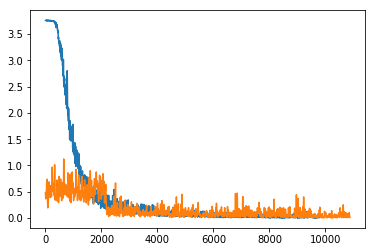

recent state in the last 100 batches -- 


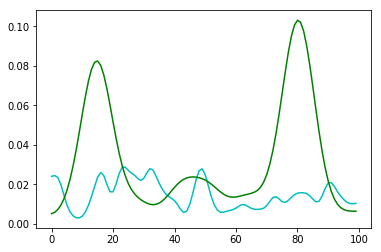

epoch -  5   current lr =  0.04131  epoch_avg_loss =  0.0018703118839007834   validation_average_loss =  0.05305271167410428


In [160]:
train_one_epoch(train_loader, 5) 



In [161]:
nn_name = "5_epochs_traffic_eye_first.pth"

torch.save(doggonet, nn_name)

/home/mayukh09/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
